<a href="https://colab.research.google.com/github/cs-pub-ro/ML/blob/master/lab/lab8/Laborator_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rețele neurale pentru clasificarea imaginilor

_Tudor Berariu, 2018_ 
_Alexandru Sorici, 2024_

În cadrul acestui laborator veți implementa o rețea neurală pentru clasificarea imaginilor.
Rețeaua va fi compusă din straturi lineare și activări de tip ReLU și un strat softmax înainte de ieșiri. Funcția de cost folosită va fi negative log likelihood. Pentru optimizarea acesteia se va folosi SGD (stochastic gradient descent).

## 1. Setul de date MNIST

Setul de date MNIST este compus din imagini de 28x28 pixeli reprezentând una dintre cele zece cifre 0-9.

Decomentați mai jos comanda `!pip install mnist` pentru a instala pachetul `mnist`.

In [15]:
# !pip install mnist
# import mnist

import gzip
import sys
import pickle

import urllib.request

url = "https://s3.amazonaws.com/img-datasets/mnist.pkl.gz"
filename = "mnist.pkl.gz"

urllib.request.urlretrieve(url, filename)


f = gzip.open('mnist.pkl.gz', 'rb')
if sys.version_info < (3,):
    data = pickle.load(f)
else:
    data = pickle.load(f, encoding='bytes')
f.close()
(train_imgs, train_labels), (test_imgs, test_labels) = data



### Exemple din setul de date MNIST

In [16]:
from typing import List
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

Labels: [0 3 9 6 5 6 8 1 0 2 5 0 2 4 0]


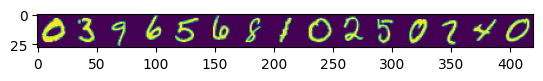

In [17]:
idxs = np.random.randint(0, len(train_imgs), 15)
imgs = np.concatenate(tuple(train_imgs[idx,:,:] for idx in idxs), axis=1)
plt.imshow(imgs)
print("Labels:", train_labels[idxs])

### Standardizarea datelor

Datele de intrare (imaginile) vor fi rescalate pentru a avea media zero și deviația standard 1.

In [18]:
mean, std  = train_imgs.mean(), train_imgs.std()
train_imgs = (train_imgs - mean) / std
test_imgs = (test_imgs - mean) / std

Justificare:

- __Media__ poate fi considerata diferenta dintre o imagine mai luminoasa si una mai intunecoasa, fapt ce nu ar trebui sa influenteze predictia retelei. Avand media zero, rețeaua va fi indiferentă la variatii in luminozitatea imaginilor. In caz contrar ar trebui sa isi modifice termenii de bias pentru a compensa diferentele.

- __Varianta__ poate fi considerata diferenta dintre o imagine cu mai mult contrast si una cu mai putin contrast, din nou, diferente ce nu ar trebui sa afecteze predictia retelei.

## 2. Construirea unei rețele de tip feed-forward

### Notații
  - dimensiunea datelor de intrare este $D = 28 * 28 = 784$, iar dimensiunea ieșirilor rețelei este $K=10$ (numărul de clase)
  - rețeaua neurală va avea $L$ straturi
  - $B$ va reprezenta dimensiunea batch-ului (numărul de exemple trecute în același timp prin rețea)
  - Vom nota cu ${\bf X} \in {\mathbb R}^{B \times D}$ un batch de intrări $\left\lbrace {\bf x}_0, {\bf x}_1, \dots {\bf x}_B \right\rbrace$ și similar ${\bf Y} \in {\mathbb R}^{B \times K}$
  - ${\bf x}^{(l)}$ reprezintă intrările stratului $l$ (${\bf x}^{(0)}$ va fi o imagine precum cele din setul MNIST de dimensiune $D$)
  - ${\bf y}^{(l)}$ reprezintă ieșirile stratului $l$ (${\bf y}^{(L-1)}$ reprezintă ieșirile rețelei)
  - ${\bf \theta}^{(l)}$ reprezintă parametrii stratului $l$
  - ${\cal L}$ reprezintă funcția de cost ( _negative log likelihood_ )
  

### Straturile rețelei

Unele straturi au parametri ce trebuie optimizați în timpul antrenării. Vom nota parametrii stratului $l$ cu $\bf{\theta}^{(l)}$.
Fiecare strat pe care îl veți implementa va avea trei metode:
 - `forward` calculează și întoarce ${\bf y}^{(l)} = f_l\left({\bf x}^{(l)}, {\bf \theta}^{(l)}\right)$
 - `backward` primește $\frac{\partial {\cal L}}{\partial {\bf y}^{(l)}}$, reține intern $\frac{\partial {\cal L}}{\partial {\bf \theta}^{(l)}}$ și întoarce $\frac{\partial {\cal L}}{\partial {\bf x}^{(l)}}$
 - `update` modifică parametrii locali ${\bf \theta}^{(l)}$ folosing gradientul stocat $\frac{\partial{\cal L}}{\partial{\bf \theta}^{(l)}}$

In [19]:
class Layer:

    def forward(self, x: np.ndarray) -> np.ndarray:
        raise NotImplementedError
        
    def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
        raise NotImplementedError
        
    def update(self, *args, **kwargs):
        pass  # If a layer has no parameters, then this function does nothing

### Rețeaua neurală

  * în faza `forward` ieșirile stratului $l$ devin intrările stratului $l+1$: ${\bf x}^{(l+1)} = {\bf y}^{(l)}$
  * în faza `backward` gradientul în raport cu intrările stratului $l+1$ devine gradientul în raport cu ieșirile stratului $l$: $\frac{\partial {\cal L}}{\partial {\bf y}^{(l)}}=\frac{\partial {\cal L}}{\partial {\bf x}^{(l+1)}}$
  
**[Cerința 0]** Completați metoda `backward` din clasa `FeedForwardNetwork`.

In [20]:
class FeedForwardNetwork:

    def __init__(self, layers: List[Layer]):
        self.layers = layers
        
    def forward(self, x: np.ndarray, train: bool = True) -> np.ndarray:
        self._inputs = []
        for layer in self.layers:
            if train:
                self._inputs.append(x)
            x = layer.forward(x)
        return x
    
    def backward(self, dy: np.ndarray) -> np.ndarray:
        # TODO <0> : Calculati gradientul cu fiecare strat
        # Pasi:
        #   - iterati in ordine inversa prin straturile retelei si apelati pentru fiecare dintre ele metoda backward
        #   - folositi self._inputs salvate la fiecare pas din forward pentru a calcula gradientul cu respectivul strat
        #   - transmiteti mai departe valoarea returnata de metoda backward catre urmatorul strat
        #   - incepeti cu gradientul fata de output (dy, primit ca argument).
        
        for i, layer in reversed(list(enumerate(self.layers))):
            dy = layer.backward(self._inputs[i], dy)
        return dy

    def update(self, *args, **kwargs):
        for layer in self.layers:
            layer.update(*args, **kwargs)

### Stratul linear

Un strat linear cu $M$ intrări și $N$ ieșiri are parametrii $\theta = \left( {\bf W}, {\bf b} \right)$ unde ${\bf W} \in \mathbb{R}^{M \times N}$ și ${\bf b} \in \mathbb{R}^{N}$.

Pentru un singur exemlu ${\bf x} \in {\mathbb R}^{M}$:
$$ {\bf y} = {\bf x}^{\intercal}{\bf W} + {\bf b} $$

**[Cerința 1]** Implementați metoda `forward` care primește un batch de exemple $X \in {\mathbb R}^{B\times M}$ și întoarce ieșirile corespunzătoare: $Y \in {\mathbb R}^{B\times N}$.

**[Cerința 2]** Implementați metoda `backward` care primește un batch de exemple $X \in {\mathbb R}^{B\times M}$ și gradientul în raport cu ieșirile $\frac{\partial {\cal L}}{\partial {\bf Y}}$ și realizează două lucruri:
  - calculează și salvează intern gradientul $\frac{\partial {\cal L}}{\partial {\bf \theta}}$
    - `self.dweight =` $ X^T \frac{\partial \mathcal{L}}{\partial \mathbf{Y}} $
    
    - `self.dbias =` $ \sum_{i=1}^{batch size} \frac{\partial \mathcal{L}}{\partial \mathbf{Y}_i} $

  - calculează și întoarce gradientul $\frac{\partial {\cal L}}{\partial {\bf X}}$
    
    - `return ` $ \frac{\partial \mathcal{L}}{\partial \mathbf{Y}} \theta^T $


In [21]:
class Linear(Layer):
    
    def __init__(self, insize: int, outsize: int) -> None:
        bound = np.sqrt(6. / insize)
        self.weight = np.random.uniform(-bound, bound, (insize, outsize))
        self.bias = np.zeros((outsize,))
        
        self.dweight = np.zeros_like(self.weight)
        self.dbias = np.zeros_like(self.bias)
   
    def forward(self, x: np.ndarray) -> np.ndarray:
        # TODO <1>: calculați ieșirea unui strat liniar
        # x - este o matrice numpy B x M, unde 
        #    B - dimensiunea batchului, 
        #    M - dimensiunea caracteristicilor de intrare (insize)
        # Sugestie: folosiți înmulțirea matricială numpy pentru a implementa propagarea înainte într-o singură trecere
        # pentru toate exemplele din batch

        return x @ self.weight + self.bias
    
    def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
        # TODO <2> : calculați dweight, dbias și returnați dx
        # x - este o matrice numpy B x M, unde 
        #     B - dimensiunea batchului, 
        #     M - dimensiunea caracteristicilor (features) de intrare (insize)
        # dy - este o matrice numpy B x N, unde 
        #     B - dimensiunea batchului, 
        #     N - dimensiunea caracteristicilor (features) de ieșire (outsize)
        # Sugestie: folosiți înmulțirea matricială numpy pentru a implementa propagarea înapoi într-o singură trecere 
        #       pentru self.dweight
        # Sugestie: folosiți numpy.sum pentru a implementa propagarea înapoi într-o singură trecere pentru self.dbias

        self.dweight = x.T @ dy
        self.dbias = np.sum(dy, axis=0)
        return dy @ self.weight.T
    
    def update(self, mode='SGD', lr=0.001, mu=0.9):
        if mode == 'SGD':
            self.weight -= lr * self.dweight
            self.bias -= lr * self.dbias
        else:
            raise ValueError('mode should be SGD, not ' + str(mode))

### Functia Rectified Linear Unit

Stratul ReLU aplică următoare următoare transformare neliniară element cu element  (vezi grafic):
$$y = \max\left(x, 0\right)$$

Prin urmare gradientul (derivata) functiei ReLU este:

$$ \text{ReLU}'(x) = \begin{cases} 
0 & \text{pentru } x < 0 \\
1 & \text{pentru } x > 0 \\
\text{nedefinit} & \text{pt } x = 0 
\end{cases} $$

Pentru a evita portiunea nedefinita, conventia in ML este sa consideram ca gradientul in 0 este 0 (uneori considerat si ca 0.5). Astfel, gradientul devine:

$$ \text{ReLU}'(x) = \begin{cases} 
0 & \text{pentru } x \leq 0 \\
1 & \text{pentru } x > 0 
\end{cases} $$

**[Cerințele 3-4]** Implementați metodele `forward` și `backward` pentru un strat de activare ReLU.


In [22]:
class ReLU(Layer):
    
    def __init__(self) -> None:
        pass
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        return np.maximum(x, 0)
    
    def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
        # TODO <4> : Calculați gradientul față de x
        # x - este o matrice numpy B x M, unde B - dimensiunea batchului, M - dimensiunea caracteristicilor
        # Sugestie: utilizați indexarea logică numpy pentru a determina unde intrarea (x) este negativă
        #       și faceți gradientul 0 pentru acele exemple
        return dy * (x > 0)

## 3. Funcția de cost

Funcția de cost pe care o vom folosi este _cross entropy_ care combină un _softmax_ și un cost _negative log-likelihood_. (Matematica la tablă)

Dacă ${\bf y}$ reprezintă ieșrile rețelei pentru o intrare ${\bf x}$, atunci ${\bf y}$ va avea o dimensiune egală cu numărul de clase $K$. Atunci probabilitatea (prezisă de rețea) ca exemplul ${\bf x}$ să aparțină clasei $k$ va fi $p_k$:
$$\begin{align}
p_k &= \frac{e^{y_k}}{\sum_j e^{y_j}} & & \text{softmax} \\
{\cal L} &= -\log p_t & & \text{negative log-likelihood}
\end{align}$$


Pentru un batch de dimensiune $B$ se va face media costurilor corespunzătare fiecărui exemplu ($p_k$ este o funcție de ${\bf x}$ și ${\bf \theta}$):

$$ {\cal L} = \frac{1}{B} \sum_{({\bf x}, {\bf t}) \in Batch} -\log p_t \left({\bf x}, \theta\right) $$

Derivata softmax-ului în raport cu logits se calculează astfel:

$$
\frac{\partial p_k}{\partial y_i} = p_k (\delta_{ki} - p_i)
$$

unde $\delta_{ki}$ este delta Kronecker, care este 1 dacă $k = i$ și 0 altfel:

$$
\delta_{ij} = 
\begin{cases} 
1 & \text{pentru } i = j \\
0 & \text{pentru } i \neq j
\end{cases}
$$

Derivata funcției de cost în raport cu logit-ul pentru clasa $i$ devine:

$$
\frac{\partial {\cal L}}{\partial y_i} = p_i - \delta_{ti}
$$

pentru orice clasă $i$, unde $t$ este clasa adevărată.

În contextul unui batch de exemple, formula pentru calculul gradientului mediu în raport cu fiecare parametru $\theta$ al rețelei este:

$$
\frac{\partial {\cal L}}{\partial \theta} = \frac{1}{B} \sum_{({\bf x}, {\bf t}) \in Batch} \sum_{i} \left(p_i - \delta_{ti}\right) \frac{\partial y_i}{\partial \theta}
$$

Unde $\frac{\partial y_i}{\partial \theta}$ este gradientul logit-ului $y_i$ în raport cu parametrii $\theta$.


**[Cerințele 5-6]** Implementați metodele `forward` și `backward` pentru un funcția de cost _cross-entropy_ (o vom privi ca pe un strat suplimentar).

In [23]:
class CrossEntropy:
    
    def __init__(self):
        pass
    
    def softmax(self, x):
        exps = np.exp(x)
        return exps / np.sum(exps,axis = 1).reshape(-1,1)

    def forward(self, y: np.ndarray, t: np.ndarray) -> float:
        # TODO <5> : Calculați probabilitatea logaritmică negativă
        # y - matrice numpy (B, K), unde B - dimensiunea batch-ului, K - numărul de clase (numărul de logaritmi)
        # t - vector numpy (B, ), unde B - dimensiunea batch-ului, care indică clasa corectă
        # Pasi: 
        #   - folositi softmax() pe intrari pentru a transforma logits (y) in probabilitati
        #   - selectati probabilitatile care corespund clasei reale (t)
        #   - calculati -log() peste probabilitati
        #   - impartiti la batch size pentru a calcula valoarea medie peste toate exemplele din batch

        probs = self.softmax(y)
        return -np.mean(np.log(probs[np.arange(len(probs)), t]))
    
    def backward(self, y: np.ndarray, t: np.ndarray) -> np.ndarray:
        # TODO <6> : Calculati dl/dy
        # Pasi: 
        #   - calculati softmax(y) pentru a determina probabilitatea ca fiecare element sa apartina clasei i
        #   - ajustati gradientii pentru clasa corecta: aplicati scaderea dL/dy_i = pi - delta_ti conform formulelor de mai sus
        #   - impartiti la batch size pentru a calcula valoarea medie peste toate exemplele din batch
        probs = self.softmax(y)
        probs[np.arange(len(probs)), t] -= 1
        return probs / len(t)


### Acuratețea

**[Cerința 7]** Calculați acuratețea predicțiilor ${\bf y}$ în raport cu clasele corecte ${\bf t}$ (rația exemplelor pentru care clasa corectă a avut probabilitatea prezisă maximă).

In [24]:
def accuracy(y: np.ndarray, t: np.ndarray) -> float:
    # TODO <7> : Calculati acuratetea
    # Pasi: 
    # - folosiți np.argmax() pentru a afla predictiile retelei
    # - folositi np.sum() pentru a numara cate sunt corecte comparand cu ground truth (t)
    # - impartiti la batch size pentru a calcula valoarea medie peste toate exemplele din batch
    return np.mean(np.argmax(y, axis=1) == t)

## Teste

Executați ```test0() and test16() and test7()``` pentru a rula testele.

In [25]:
def test0():
    fakex = [np.random.randn(128, n) for n in [20, 40, 30, 10]]

    class DummyLayer:
        def __init__(self, idx):
            self.idx = idx

        def forward(self, x):
            return fakex[self.idx + 1]

        def backward(self, x, dldy):
            if not np.allclose(x, fakex[self.idx]):
                raise Exception("Intrări greșite în backward")
            if not np.allclose(dldy, -fakex[self.idx+1]):
                raise Exception("Intrări greșite în backward")
            return -x

    try:
        net = FeedForwardNetwork([DummyLayer(i) for i in range(3)])
        net.forward(fakex[0])
        net.backward(-fakex[-1])
        print("Cerința 0 rezolvată corect!")
        return True
    except NotImplementedError as e:
        print("Cerința 0 nu a fost implementată!")
    except Exception as e:
        print(e)
        print("Cerința 0 are erori.")
        
    return False
        
def test16():
    __x = np.array([[-3.0731, -1.9081, -0.7283, -0.0757, -0.7577],
                    [ 2.4041, -1.1506, -0.5924,  1.3016,  1.0882],
                    [-0.5254,  0.3519, -0.9633, -2.7393, -0.9745]])
    __w = np.array([[ 1.3214, -0.5886, -0.0351,  1.2084,  1.2661, -0.9979, -0.1172],
                    [-0.4022,  0.1168,  0.9020, -2.0098, -0.5409, -0.3876, -0.1719],
                    [-1.1125, -0.5556,  0.8843,  0.6995,  0.4929,  0.7523,  0.1832],
                    [ 0.2267,  0.6757,  1.1286, -0.3218,  1.6934, -0.1782, -0.3467],
                    [-0.6062,  0.4426,  0.5090,  0.4772, -0.5721,  0.8658, -0.5999]])
    __b = np.array([ 0.3335,  0.5051, -0.1393,  1.2116,  1.7836, -0.6597,  0.3553])
    __y = np.array([[-1.70746622, 2.10919555, -2.8676804, 0.48630531, -1.1288499, 1.95609904, 1.39083457],
                    [4.26749994, 0.64592254, 0.23749513, 6.11524068, 6.73936681, -2.34822291, -0.94127596],
                    [0.5391161, -0.89159687, -4.24288533, -0.38789499, -3.62798139, -1.35206921, 1.71422657]])
    
    __dy = np.array([[ 1.5555, -0.8978, -0.2917, -0.3868, -0.8257, -0.3491, -0.8658],
                     [ 1.1146,  1.4914,  0.9591, -0.2613,  0.5887,  0.4794,  0.8565],
                     [-0.1552, -1.6319,  1.7642,  1.0503,  0.1035 , -0.7186, -0.9782]])
    __dx = np.array([[ 1.53113221,  0.51455541, -2.588423,   -1.49460989, -0.98384103],
                     [ 0.41215308,  0.46469672, -0.59552791,  3.04147235, -0.08763244],
                     [ 2.92549149, -0.25707023,  2.70531668,  1.15769427,  0.67643021]])
    __dw = np.array(
        [[-2.01905511,  7.20190418,  2.2752849,   0.00865613,  3.89837344,  2.60289719, 5.23374791],
         [-4.30512319, -0.57717827,  0.07387429,  1.40830543,  0.9345816,  -0.13835527, 0.3223155 ],
         [-1.64365553,  1.34237165, -2.05517959, -0.57525343,  0.15290988,  0.66248035, 1.0654716 ],
         [ 1.75815137,  6.47943337, -3.56222681, -3.18791411,  0.54523986,  2.61887489, 3.85994472],
         [ 0.18554777,  3.89349109, -0.45449919, -1.01478565,  1.16539548,  1.48647185, 2.54131586]]
    )
    __db = np.array([ 2.5149, -1.0383,  2.4316,  0.4022, -0.1335, -0.5883, -0.9875])
    
    __y_relu = np.array([[0, 2.10919555, 0, 0.48630531, 0, 1.95609904, 1.39083457],
                         [4.26749994, 0.64592254, 0.23749513, 6.11524068, 6.73936681, 0, 0],
                         [0.5391161, 0, 0, 0, 0, 0, 1.71422657]])
    __drelu = np.array([[0, -0.8978, 0, -0.3868, 0, -0.3491, -0.8658],
                        [ 1.1146,  1.4914,  0.9591, -0.2613,  0.5887,  0,  0],
                        [-0.1552, 0,  0,  0,  0 , 0, -0.9782]])
    
    __t = np.array([3, 1, 2])
    __dl_dy = np.array(
        [[ 2.80870645e-03,  1.27661957e-01,  8.80302096e-04, -3.08142112e-01,
           5.00952130e-03,  1.09539948e-01,  6.22416775e-02],
         [ 1.73238217e-02, -3.32870086e-01,  3.07917841e-04,  1.09927743e-01,
           2.05192672e-01,  2.31991342e-05,  9.47329526e-05],
         [ 6.60308812e-02,  1.57905168e-02, -3.32780047e-01,  2.61307149e-02,
           1.02329216e-03,  9.96358772e-03,  2.13841054e-01]]
    )


    try:
        lin = Linear(5, 7)
        lin.weight = __w.copy()
        lin.bias = __b.copy()
        y = lin.forward(__x.copy())
        if not np.allclose(y, __y):
            raise Exception("Ieșiri greșite")
        print("Cerința 1 rezolvată corect!")
    except NotImplementedError as e:
        print("Cerința 1 nu a fost implementată!")
        return False
    except Exception as e:
        print(e)
        print("Cerința 1 are erori.")
        return False
        
    try:
        dx = lin.backward(__x.copy(), __dy.copy())
        if not np.allclose(dx, __dx):
            raise ValueError("dL/dx greșit")
        if not np.allclose(lin.dweight, __dw):
            raise ValueError("dL/dw greșit")
        if not np.allclose(lin.dbias, __db):
            raise ValueError("dL/db greșit")
        print("Cerința 2 rezolvată corect!")
    except NotImplementedError as e:
        print("Cerința 2 nu a fost implementată!")
        return False
    except Exception as e:
        print(e)
        print("Cerința 2 are erori.")
        return False

    try:
        relu = ReLU()
        y_relu = relu.forward(__y.copy())
        if not np.allclose(y_relu, __y_relu):
            raise ValueError("ReLU(x) greșit")
        print("Cerința 3 rezolvată corect!")
    except NotImplementedError as e:
        print("Cerința 3 nu a fost implementată!")
        return False
    except Exception as e:
        print(e)
        print("Cerința 3 are erori.")
        return False
            
    try:
        relu = ReLU()
        drelu = relu.backward(__y.copy(), __dy.copy())
        if not np.allclose(drelu, __drelu):
            raise ValueError("ReLU.backward greșit")
        print("Cerința 4 rezolvată corect!")
    except NotImplementedError as e:
        print("Cerința 4 nu a fost implementată!")
        return False
    except Exception as e:
        print(e)
        print("Cerința 4 are erori.")
        return False
    
    try:
        ce = CrossEntropy()
        loss = ce.forward(__y.copy(), __t.copy())
        if np.abs(loss - 5.1874357237332545) > 1e-6:
            raise ValueError(f"Valoare greșită nll: {loss:f} în loc de 5.1874357237332545")
        print("Cerința 5 rezolvată corect!")
    except NotImplementedError as e:
        print("Cerința 5 nu a fost implementată!")
        return False
    except Exception as e:
        print(e)
        print("Cerința 5 are erori.")
        return False
    
    try:
        ce = CrossEntropy()
        dl_dy = ce.backward(__y.copy(), __t.copy())
        if not np.allclose(dl_dy, __dl_dy) > 1e-6:
            raise ValueError(f"Valoare greșită pentru dNLL/dy")
        print("Cerința 6 rezolvată corect!")
    except NotImplementedError as e:
        print("Cerința 6 nu a fost implementată!")
        return False
    except Exception as e:
        print(e)
        print("Cerința 6 are erori.")
        return False
    
    return True

def test7():  # Acuratețea
    y = np.array([[ 0.6460014 , -0.05876393, -1.36496105, -0.07057596,  0.54938383],
                  [-0.8033942 , -0.51753041,  0.92278036, -1.66303585, -0.36537512],
                  [-1.3710599 ,  0.65598193, -0.75527154,  1.21609284,  0.08284123],
                  [-1.24696857,  0.32676634,  0.09572539,  1.38316398, -0.14110726],
                  [-2.01698315,  2.06123375, -1.68003675,  0.0504592 ,  0.04427597],
                  [-0.8893451 ,  1.74695148, -0.29394473,  0.74203068, -0.75185261],
                  [ 1.34126333, -0.5272606 ,  1.46458319,  1.59529987,  1.86884676],
                  [-0.58987297,  1.10900165, -0.71208103,  0.20478154, -1.26693567],
                  [-2.17730677, -1.36147532, -1.49679182,  0.24812177, -0.13368035],
                  [-0.48730599,  1.31710647,  0.41765538,  1.19869192, -0.05301611],
                  [-0.10655224, -0.21174034,  1.31548647, -0.57990281,  0.85868472],
                  [-0.32055613, -2.17817118, -0.28488692,  1.62977524,  0.25150929],
                  [ 0.07704727,  1.67710047,  1.83368441, -0.45456845, -0.74474969]])
    t = np.array([0, 2, 3, 3, 1, 0, 1, 1, 2, 1, 2, 3, 2])
    try:
        acc = accuracy(y, t)
        if np.abs(acc - 0.7692307692307693) > 1e-7:
            raise ValueError(f"{acc:f} != 10/13")
        print(f"Cerința 7 rezolvată corect!")
    except NotImplementedError as e:
        print("Cerința 7 nu a fost implementată!")
    except Exception as e:
        print(e)
        print("Cerința 7 are erori.")
    

In [27]:
test0() and test16() and test7()

Cerința 0 rezolvată corect!
Cerința 1 rezolvată corect!
Cerința 2 rezolvată corect!
Cerința 3 rezolvată corect!
Cerința 4 rezolvată corect!
Cerința 5 rezolvată corect!
Cerința 6 rezolvată corect!
Cerința 7 rezolvată corect!


## 4. Antrenarea rețelei neurale

**[Cerința 8]** Completați codul de mai jos pentru a calcula gradientul funcției de cost pentru batchul ales și parametrii curenți ai rețelei.

_Indiciu_: trebuie să apelați metodele `forward` și `backward` ale rețelei neurale și ale funcției de cost.


In [28]:
BATCH_SIZE = 128
HIDDEN_UNITS = 300
EPOCHS_NO = 20

optimize_args = {'mode': 'SGD', 'lr': .005}

net = FeedForwardNetwork([Linear(784, HIDDEN_UNITS),
                          ReLU(),
                          Linear(HIDDEN_UNITS, 10)])
cost_function = CrossEntropy()

for epoch in range(EPOCHS_NO):
    for b_no, idx in enumerate(range(0, len(train_imgs), BATCH_SIZE)):
        # 1. Pregatim urmatorul batch
        x = train_imgs[idx:idx + BATCH_SIZE,:,:].reshape(-1, 784)
        t = train_labels[idx:idx + BATCH_SIZE]
        
        # 2. Calculam gradientul
        # TODO <8>:
        # Hint: propagam batch-ul `x` prin reteaua `net`
        #       calculam eroarea pe baza iesirii retelei, folosind `cost_function` 
        #       obtinem gradientul erorii in raport cu iesirea retelei, folosind `backward` pentru `cost_function`
        #       obtinem gradientul in raport cu ponderile retelei `net` folosind `backward` pentru `net`
        y = net.forward(x)
        loss = cost_function.forward(y, t)
        dy = cost_function.backward(y, t)
        net.backward(dy)
        
        # 3. Actualizam parametrii retelei
        net.update(**optimize_args)
        
        print(f'\rEpoch {epoch + 1:02d} '
              f'| Batch {b_no:03d} '
              f'| Train NLL: {loss:6.3f} '
              f'| Train Acc: {accuracy(y, t) * 100:6.2f}% ', end='')

    y = net.forward(test_imgs.reshape(-1, 784), train=False)
    test_nll = cost_function.forward(y, test_labels)
    print(f'| Test NLL: {test_nll:6.3f} '
          f'| Test Acc: {accuracy(y, test_labels) * 100:3.2f}%')

Epoch 01 | Batch 468 | Train NLL:  0.438 | Train Acc:  90.62% | Test NLL:  0.402 | Test Acc: 88.84%
Epoch 02 | Batch 468 | Train NLL:  0.341 | Train Acc:  94.79% | Test NLL:  0.321 | Test Acc: 91.10%
Epoch 03 | Batch 468 | Train NLL:  0.309 | Train Acc:  95.83% | Test NLL:  0.284 | Test Acc: 92.12%
Epoch 04 | Batch 468 | Train NLL:  0.291 | Train Acc:  95.83% | Test NLL:  0.261 | Test Acc: 92.74%
Epoch 05 | Batch 468 | Train NLL:  0.279 | Train Acc:  95.83% | Test NLL:  0.244 | Test Acc: 93.13%
Epoch 06 | Batch 468 | Train NLL:  0.270 | Train Acc:  96.88% | Test NLL:  0.231 | Test Acc: 93.53%
Epoch 07 | Batch 468 | Train NLL:  0.263 | Train Acc:  96.88% | Test NLL:  0.220 | Test Acc: 93.83%
Epoch 08 | Batch 468 | Train NLL:  0.257 | Train Acc:  96.88% | Test NLL:  0.210 | Test Acc: 94.09%
Epoch 09 | Batch 468 | Train NLL:  0.251 | Train Acc:  97.92% | Test NLL:  0.202 | Test Acc: 94.37%
Epoch 10 | Batch 468 | Train NLL:  0.246 | Train Acc:  97.92% | Test NLL:  0.195 | Test Acc: 94.57%
